## Example script of calculation of dose measured by AIRDOS04

The following code demonstrates the method how to calculate radiation dose detected by silicon semiconductor based dosimeter [AIRDOS04A](https://docs.dos.ust.cz/airdos/AIRDOS04). The following proces expect the user is familiar with concept of [jupiter notebooks](https://jupyter.org/) and have a basic knowledge of [Python3](https://www.python.org/) programming language.

For demonstration we use an data recording contained in the AIRDOS04 repository. The recording contains a travel of AIRDOS04 as airmail package from Europe to Asia. The original recording contains multiple transfers and handling for over 150 hour of travel to keep simplicity and data storage saving the recording has been manually shortened to only one flight. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import re

directory = './data/' # Directory with data 

FIRST_CHANNEL = 8 # a column of the 1st channel without noise
ZERO_CHANNEL = 4 # a column of the channel with maximal noise
CH_WIDTH = 0.0066 # [MeV]

Because the AIRDOS04 originally produces multiple files to record data in sufficiently long chunks, there could be multiple text files, which wee need to concanetate along measurement runs. The example recorded file has been anonymised therefore serial numbers here are displayed as `ffffffffffffffffffffffffffffffff` for valid AIRDOS04 product, there should be an proper serial number of the device. 

In [2]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

df=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.TXT'), key=numericalSort)
for file in files:
    print(file)
    l=[]
    l.extend(range(0,1028))
    f = pd.read_csv(file, sep=',', header=None, names=l, comment='*', low_memory=False)
    try:
        sn = f.loc[f[0]=='$DOS'].iloc[0,6]
        print("S.N.: ", sn)
    except:
        pass
    df = pd.concat([df,f], ignore_index=True)

#df = df.reset_index(drop=True)
print('All files was readed.')

./data/4.TXT
S.N.:  ffffffffffffffffffffffffffffffff
All files was readed.


As we can see there is in the example data one measurement run.  We should display a raw data data to see its content.

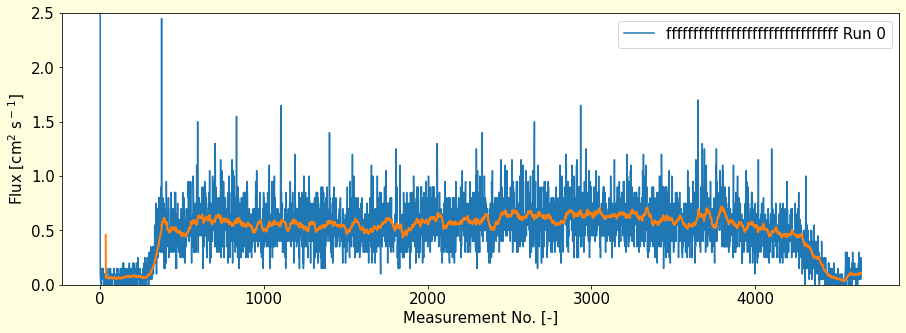

In [3]:
run = 0
df['run'] = np.nan
df = df.loc[df[0]=='$HIST'].copy()
df[2] = pd.to_numeric(df[2], errors='coerce')

try:
    for x in df.loc[df[2]<20].index:
        df.loc[x,'run'] = run
        run += 1
except:
    pass
df['run'].fillna(method="ffill", inplace=True)

df['sum'] = df.iloc[:,FIRST_CHANNEL:1028].sum(axis=1)
df['mean'] = df['sum'].rolling(30).mean()

matplotlib.rcParams.update({'font.size': 15})

for r in range(0,run):
    plt.figure(figsize=(15,5), facecolor='lightyellow')
    plt.plot(df.loc[df['run']==r]['sum']/20, label=sn+' Run '+str(r))
    plt.plot(df.loc[df['run']==r]['mean']/20, lw=2)
    plt.ylim(0,2.5)
    plt.xlabel('Measurement No. [-]')
    plt.ylabel('Flux [cm$^2$ s$^-$$^1$]')
    plt.legend(loc=1)
    plt.show()


As can be seen the run contains the one flight. The flight is a long one, which corresponds to flaight from Europe to Asia. 

Now lets plot somewhat processed data to see the phisicaly maaningfull variables like relative time instead of Measurement No. and dose rate according to accumulated energy spectra of absorbed ionization. 


0.033 0.0066


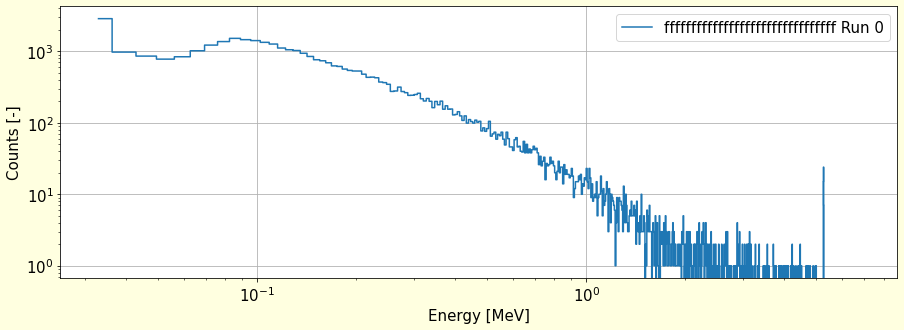

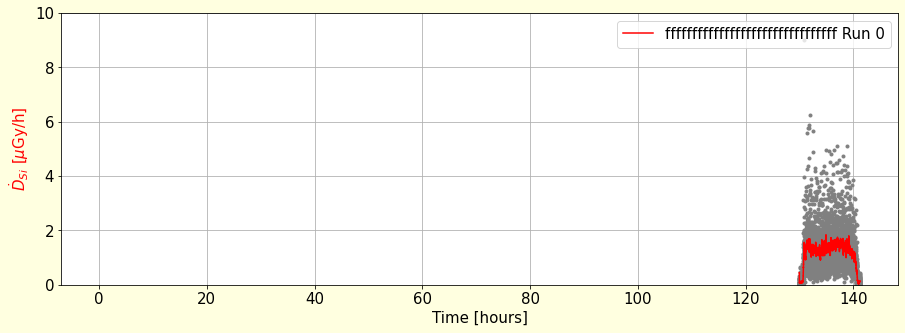

In [4]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print(coef[0], coef[1])

for r in range(0,run):
    rc = df.loc[df['run']==r].copy()
    rc[2] = pd.to_numeric(rc[2], errors='coerce')

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})

    ener = rc.iloc[:,FIRST_CHANNEL:1028].sum()
    
    e = pd.DataFrame()
    e['1'] = ener
    e['i'] = ener.index
    e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]

    plt.plot(e['x'], e['1'], drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Counts [-]')
    plt.grid()

    plt.legend()
    plt.show()
    
    
    rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:1028]) * np.asarray(e['x'])).sum(axis=1)    
    
    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1165e-3 kg
    rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

    rc['dsimean'] = rc['dsi'].rolling(30).mean()

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})
    plt.plot(rc[2]/3600,rc['dsi'], c='gray', linestyle='', marker='.')
    plt.plot(rc[2]/3600,rc['dsimean'],c='red', drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.ylim([0,10])

    plt.xlabel('Time [hours]')
    plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
    plt.legend(loc=1)

    plt.grid()
    plt.show()


When the Measurement No. is translated to hours, we can see the recording started around 130 hours before the flight. 
Now the doserate and total dose in silicon coud be calculed from selected parts of data records.  The calculation interval should be selected according to flighs.

In [5]:
SELECTED_RUN = 0 # Measurement run (order of power on)
FROM = 130.2 # Start time in hour
TO = 141.2 # Stop time in hour

Above code block contains predefined selection for the part of recording corresponding to flight.

0.033 0.0066


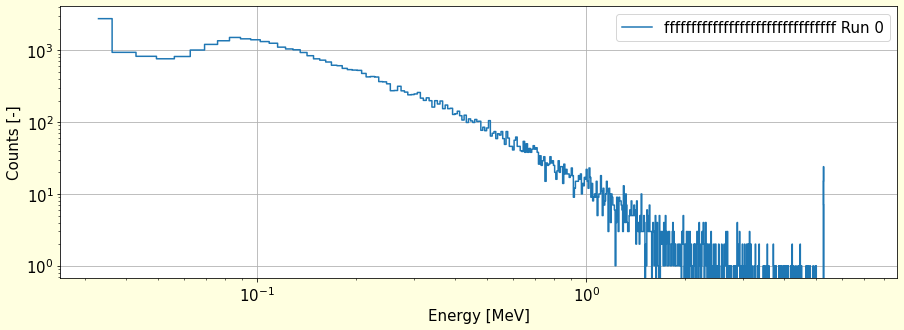

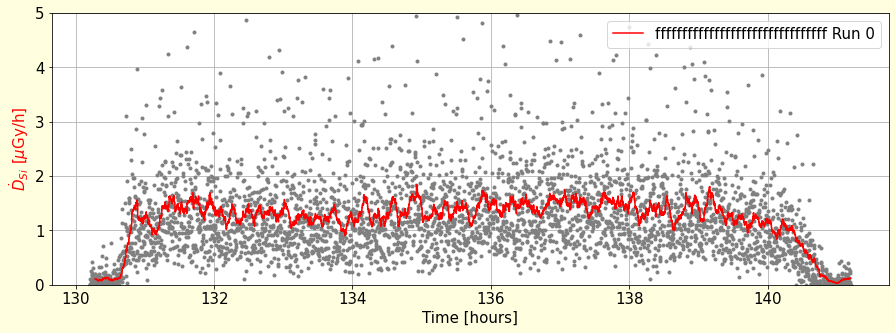

In [6]:
WINDOW = 30

coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print(coef[0], coef[1])

r = SELECTED_RUN
rc = df.loc[df['run']==SELECTED_RUN].loc[df[2]>=FROM*3600].loc[df[2]<=TO*3600].copy()
rc[2] = pd.to_numeric(rc[2], errors='coerce')

plt.figure(figsize=(15,5), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

ener = rc.iloc[:,FIRST_CHANNEL:1028].sum()

e = pd.DataFrame()
e['1'] = ener
e['i'] = ener.index
e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]

plt.plot(e['x'], e['1'], drawstyle='steps-mid', label=sn+' Run '+str(r))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts [-]')
plt.grid()

plt.legend()
plt.show()


rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:1028]) * np.asarray(e['x'])).sum(axis=1)    

# size of the chip (20 mm · 10 mm), 
# the thickness of the depletion layer (0.3 mm), 
# and the density of silicon (2.33 g cm^3)
# 0.1165e-3 kg
rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

rc['dsimean'] = rc['dsi'].rolling(WINDOW).mean()

plt.figure(figsize=(15,5), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})
plt.plot(rc[2]/3600,rc['dsi'], c='gray', linestyle='', marker='.')
plt.plot(rc[2]/3600,rc['dsimean'],c='red', drawstyle='steps-mid', label=sn+' Run '+str(r))

plt.ylim([0,5])

plt.xlabel('Time [hours]')
plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
plt.legend(loc=1)

plt.grid()
plt.show()


Here we can see a detail of the selected part of the recording.

In [7]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print('Min. sensitivity', coef[0], '[MeV], Channel width', coef[1], '[MeV]')

df[2] = pd.to_numeric(df[2], errors='coerce')
rc = df.loc[df['run']==SELECTED_RUN].loc[df[2]>=FROM*3600].loc[df[2]<=TO*3600].copy()

ener = rc.iloc[:,FIRST_CHANNEL:1028].sum()
e = pd.DataFrame()
e['1'] = ener
e['i'] = ener.index
e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]
rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:1028]) * np.asarray(e['x'])).sum(axis=1)    

# size of the chip (20 mm · 10 mm), 
# the thickness of the depletion layer (0.3 mm), 
# and the density of silicon (2.33 g cm^3)
# 0.1165e-3 kg
rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

print('S.N.',sn)
print('Run '+str(SELECTED_RUN),' From', FROM, '[hour] to', TO, '[hour], Duration', round(TO-FROM,1),'[hour]')
mean_doserate = rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'].mean()
measurements = len(rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'])
print('Mean Dose Rate\033[1m',round(mean_doserate,2),'\033[0m[μGy/h]')
print('Dose in silicon\033[1m',round(mean_doserate * (TO-FROM),2),'±',round(3*rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'].sem(),2),'\033[0m[μGy]')    


Min. sensitivity 0.033 [MeV], Channel width 0.0066 [MeV]
S.N. ffffffffffffffffffffffffffffffff
Run 0  From 130.2 [hour] to 141.2 [hour], Duration 11.0 [hour]
Mean Dose Rate 1.21 [μGy/h]
Dose in silicon 13.28 ± 0.04 [μGy]


As you can see the flight gives 13.28 ± 0.04 μGy to silicon. Method of converting DSi to ambient dose equivalent H*(10) is still under scientific study and [this paper](https://www.researchgate.net/publication/49709780_Use_of_energy_deposition_spectrometer_Liulin_for_individual_monitoring_of_aircrew) could be used as a reference. Generally the corversion coefficients are individual for the each device and could be obtained by measurement at [CERF](https://tis-div-rp-cerf.web.cern.ch/).